# Artificial Neural Networks as Universal Function Approximators II
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eleni-vasilaki/rl-notes/blob/main/notebooks/08_backpropagation.ipynb)

## Function Approximation with Deep Networks

The world we live in is a complex one. There is so much detail in everything that it becomes impossible for us to capture it all precisely.

When I was little, I was fascinated by Agatha Christie’s books. In them, there’s a recurring character — an old lady who solves mysteries simply by observing human nature. She notices behaviours, compares them to people she already knows, and uses that resemblance to make sense of what’s happening. In other words, she interpolates: she takes a new situation and maps it onto familiar patterns from her past data.

What we’re going to do here is somewhat analogous — but we’ll formalise it.

In reinforcement learning, we often use a Q-table: a two-dimensional table indexed by states and actions, storing values that tell us how good a given action is in a given state. This works when the number of states and actions is small. But as soon as the state space becomes large — or worse, continuous — the table becomes intractable, and to put it bluntly, useless. The most challenging reinforcement problems today cannot be solved with Q-tables.

This is where neural networks become indispensable.

Until now, we’ve only worked with perceptrons — shallow, linear models. But to replace the Q-table in challenging problems, we’ll need something more expressive: deep networks.

Forget everything you’ve heard about deep learning — or at least, set it aside for now. Don’t think of neural networks as classifiers, or clusterers, or compressors. Think of them for what they fundamentally are: function approximators.

That’s their true power.

The function we’re going to approximate is the Q-function — which, in tabular settings, is represented as a Q-table. That is, the mapping from a given state-action pair to an expected value.

## From Perceptrons to Deeper Networks

In previous lectures, we introduced the delta rule — the update rule for the weights of a single neuron, which we freely referred to as a perceptron.

A set of perceptrons — each making independent decisions — can actually solve surprisingly non-trivial problems. A good example is the MNIST dataset. You’re likely familiar with it: it’s one of the most widely used (and overused) benchmarks in machine learning. While it was quite impressive when introduced, it now mostly belongs to education, prototyping, and early-stage testing.

For those who haven’t seen it, MNIST consists of images of digits 0 through 9, handwritten by different people and scaled to a uniform size. The task is to build a system — typically a neural network — that can correctly classify each image as the digit it represents.

Now, if you try to tackle this using just 10 perceptrons — one for each digit — you’ll find that you can already achieve around 70% accuracy, or a bit more depending on preprocessing. That may sound surprising: this seems like a hard problem, but it turns out to be easier than it looks.

The reason lies in what perceptrons do. At their core, perceptrons draw hyperplanes — they divide the input space with straight lines (or planes, or hyperplanes, depending on dimensionality). If your data can be separated using such divisions, the problem is called linearly separable.

Let’s look at a very simple example: the logical OR gate, which we discussed before. The input consists of pairs of binary values — (0, 0), (0, 1), (1, 0), and (1, 1). The output is 1 if at least one of the inputs is 1. If we plot these four points in the 2D input space, we can clearly draw a single line that separates the class 0 (which occurs only at (0, 0)) from the three other points that belong to class 1. This is a textbook example of a linearly separable problem.

Now let’s change the problem just slightly — it remains simple, but it introduces a fundamentally different geometric property. Consider the XOR gate. The input space is the same: (0, 0), (0, 1), (1, 0), and (1, 1). But now the output is 1 only when the inputs differ. In this case, no single line can separate the classes. You would need at least two lines — meaning, a combination of decision boundaries.

This makes XOR one of the simplest examples of a non-linearly separable problem — and it reveals the limitation of single-layer perceptrons. You need more structure to solve it.

And that structure comes from depth. That is, neurons arranged not just side by side, but in layers.

Let’s revisit the structure of a neuron. Its input is a linear summation: the weighted sum of the input values. But there’s one essential additional ingredient: a nonlinear activation function. That nonlinearity is critical.

Without it, it’s straightforward to show — and easy to construct counterexamples — that a network with multiple layers of purely linear operations collapses into a single linear layer. In other words, without nonlinearity, depth adds no expressive power. Nonlinearity may not be the only ingredient in modern neural networks’ success, but it is unquestionably a key one.

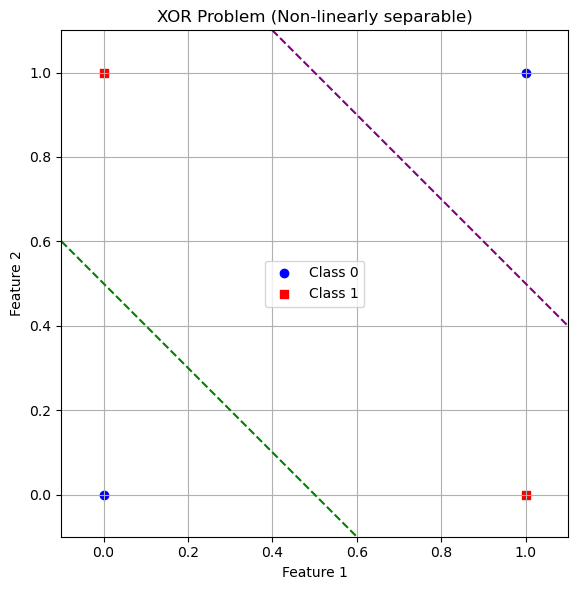

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# XOR dataset
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 0])

# Plot XOR data points
plt.figure(figsize=(6, 6))
plt.scatter(X[y == 0, 0], X[y == 0, 1],
            c='blue', marker='o', label='Class 0')
plt.scatter(X[y == 1, 0], X[y == 1, 1],
            c='red',  marker='s', label='Class 1')

# Diagonal separators spanning the whole plotting area
xs = np.linspace(-0.1, 1.1, 200)
plt.plot(xs, -xs + 0.5, '--', color='green')
plt.plot(xs, -xs + 1.5, '--', color='purple')

# Set limits with a margin and enforce square aspect ratio
ax = plt.gca()
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)
ax.set_aspect('equal', adjustable='box')

# Final touches
plt.title('XOR Problem (Non-linearly separable)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Exercise  

You are going to demonstrate the importance of the non-linear activation function through a simple example.  
Assume a small feedforward neural network with two input units, two hidden units, and one output unit.  
For simplicity, we will call the input units $x_1$ and $x_2$, the hidden units $x_3$ and $x_4$, and the output unit $x_5$.  
Their corresponding weights will be as we have defined them earlier: $w_{31}$ is the weight from unit 1 to 3, $w_{41}$ from unit 1 to 4, etc.  

- Calculate the output unit as a function of the input units.  
- Then, define a neural network with two input units and one output that, with different weights, can perform the same task. What is the mathematical relationship between the weights in the shallow network and the original ones?

<details>
<summary>Show Solution</summary>

**Network Structure:**
- **Input Units**: $x_1$ and $x_2$
- **Hidden Units**: $x_3$ and $x_4$
- **Output Unit**: $x_5$

**Weights:**
- $w_{31}$ is the weight from $x_1$ to $x_3$
- $w_{32}$ is the weight from $x_2$ to $x_3$
- $w_{41}$ is the weight from $x_1$ to $x_4$
- $w_{42}$ is the weight from $x_2$ to $x_4$
- $w_{53}$ is the weight from $x_3$ to $x_5$
- $w_{54}$ is the weight from $x_4$ to $x_5$

**Biases** (omitted for simplicity in equations):
- $b_3$, $b_4$, and $b_5$

### Calculate the Output Using Linear Activations

If all activation functions are linear (i.e., identity functions where the output equals the input), the outputs of the hidden units $x_3$ and $x_4$ are linear combinations of the inputs:

$$x_3 = w_{31} x_1 + w_{32} x_2$$
$$x_4 = w_{41} x_1 + w_{42} x_2$$

The output of the network, $x_5$, being a linear combination of the outputs from the hidden units, is:

$$x_5 = w_{53} x_3 + w_{54} x_4$$

Substituting the values of $x_3$ and $x_4$ from the above, we get:

$$x_5 = (w_{53} w_{31} + w_{54} w_{41}) x_1 + (w_{53} w_{32} + w_{54} w_{42}) x_2$$

Let:
- $W_1 = w_{53} w_{31} + w_{54} w_{41}$
- $W_2 = w_{53} w_{32} + w_{54} w_{42}$

Thus, $x_5$ simplifies to:
$$x_5 = W_1 x_1 + W_2 x_2$$

### Redefine a Simpler Network

The multi-layer linear network essentially performs as a single-layer linear network with the inputs directly connected to the output through new weights $W_1$ and $W_2$.

Equivalent Weights for the Single-Layer Network

For a single-layer network performing the same task, you directly connect $x_1$ and $x_2$ to $x_5$ with weights $W_1$ and $W_2$. These weights are equivalent to the combinations derived from the two-layer network:

$$W_1 = w_{53} w_{31} + w_{54} w_{41}$$
$$W_2 = w_{53} w_{32} + w_{54} w_{42}$$

### Conclusion

Without non-linear activation functions, adding more layers does not increase the model's capacity to learn complex patterns since it only extends the linear transformation, not contributing to additional complexity or abstraction capability. Non-linear activations enable neural networks to learn non-linear relationships, crucial for tasks like classifying non-linearly separable patterns such as XOR.

</details>


## Forward and Backward Passes

In practical terms, the operation of a neural network consists of two main phases:

1. Forward Pass:
Starting from the input layer, we propagate activity forward through the network. At each layer, we compute the weighted sum of the inputs to each neuron, apply a nonlinear activation function, and pass the result to the next layer. This process continues until we reach the output layer, where the network produces a prediction. At this point, we compute the loss — the discrepancy between the predicted output and the target.

2. Backward Pass:
Once the error is known, we propagate information backwards through the network in order to update the model’s parameters. Using the chain rule, we compute the gradient of the loss with respect to each parameter — weights and biases — and adjust them accordingly. This gradient tells us how to change each parameter to reduce the overall error, allowing the network to learn from data.

## Backpropagation and the Chain Rule

In order to derive the backpropagation update rules, we need to refer to the chain rule of differentiation. This is essential because in a multi-layer network, the effect of any one weight on the loss is indirect — it is propagated through several layers of neurons and connections, eventually influencing the output.

In this course, we have aimed to use only the mathematical tools we have introduced and proved explicitly — primarily high-school or A-level mathematics — but with a strong emphasis on practical understanding over rote memorisation. The chain rule is one such tool. While it is often introduced as a simple identity, it carries important structural assumptions that are often overlooked in simpler problems.

When it comes to neural networks, the naïve application of the chain rule — as seen in many online derivations — often leads to sloppy or incorrect results. These derivations sometimes gesture at the flavour of backpropagation without providing a rigorous path from first principles.

To do this properly, we must recognise that the dependency structure of the loss is layered. Output neurons depend on weights from the previous layer, which in turn depend on earlier layers, and so on. The cleanest way to express this is via matrix calculus, taking derivatives with respect to entire vectors or matrices. However, this goes beyond the standard background assumed in this course, and therefore, we will not adopt it here. (A future version of these notes may include it.)

Instead, we will keep our commitment to a principled derivation using only the mathematical tools we’ve already established. And to do so, we must now carefully generalise our earlier thinking.


## General Setup: The Chain Rule Applied to a Loss Function

Let us begin by considering a generic loss function, denoted by $L$. This function quantifies how well the network performs. We will first express $L$ in its online version, that is, the error computed for a single pattern (or data point). In practice, we often sum the errors over a batch of inputs, but we can safely defer that until the end. This is because:

The derivative of a sum is the sum of the derivatives.

So, for derivation purposes, we are justified in starting from a single pattern, then generalising.

The original backpropagation paper by Rumelhart, Hinton, and Williams presented the algorithm in exactly this online setting. (As you likely know, Geoffrey Hinton has since been awarded the Nobel Prize in Physics for his contributions to this area.)

Let’s define our total loss over a batch $X$ as:

$$
L = \sum_{\mathbf{x}} L_o(\mathbf{x}),
$$

where $L_o$ is the online loss corresponding to a single data point $\mathbf{x}$.

Now suppose we are interested in computing the derivative of the total loss with respect to a particular weight $w_{ij}$ (e.g. from neuron $j$ to neuron $i$). By linearity of differentiation, we have:

$$
\frac{\partial L}{\partial w_{ij}} = \sum_{\mathbf{x} } \frac{\partial L_o(\mathbf{x})}{\partial w_{ij}}.
$$

This is a structurally correct starting point for our derivation. We now focus on computing $\frac{\partial L_o}{\partial w_{ij}}$ for a single datapoint $\mathbf{x}$ using the chain rule. This requires us to track how changes in the weight affect the output neuron, and how that in turn affects the loss.



## Gradient Flow Through the Network

To compute this gradient, we begin by considering the derivative of the online loss function with respect to the parameter that we’re updating.

We start by recalling that the loss function $L_o$ is a scalar. It measures the error — which, in our case, is effectively a sum across the errors of each output neuron.

So we begin by considering the partial derivative of the online loss with respect to a single output neuron, say $y_i$, where $i$ indexes neurons in the output layer. That derivative,
$$
\frac{\partial L_o}{\partial y_i},
$$
tells us the direction in which $y_i$ would have to move to reduce the error. But — crucially — we never directly change the value of a neuron. What we change are the parameters of the network — weights and biases — which in turn affect the neuron’s output.

Therefore, we need to apply the chain rule to find the effect of the weight we want to change to the specific neuron $y_i$:
$$
\frac{\partial L_o}{\partial y_i} \cdot \frac{\partial y_i}{\partial w_{ij}^{(n)}},
$$
where $w_{ij}^{(n)}$ is the weight connecting neuron $j$ in the penultimate layer to output neuron $i$. Here, $j$ indexes the $(n-1)$-th layer — the one before the output — and we explicitly use the superscript $(n)$ to track layer depth.

We might also consider a deeper weight, for example $w_{jk}^{(n-1)}$, which connects neuron $k$ in the $(n-2)$-th layer to neuron $j$ in the $(n-1)$-th. Then we compute:
$$
\frac{\partial L_o}{\partial y_i} \cdot \frac{\partial y_i}{\partial w_{jk}^{(n-1)}},
$$
with layer indices keeping our notation unambiguous.

These expressions tell us how a particular weight affects a single output neuron’s error. In other words, they give the gradient for that output only. Each output neuron would yield a different gradient — a different direction — for improving its own error.

But we care about improving the total error, not just that of a single neuron.

When a weight connects directly to the output layer, there is nothing between the weight and the output neuron it influences. In fact, the gradient of any other neuron apart from the specific output neuron of the weight is zero. So no special attention is needed there, as the effect of the weight on the error is via a single neuron.

But when the weight belongs to a deeper layer — say, the penultimate one — there are intermediate neurons in the chain of influence. We can still apply the chain rule as long as there is a direct, uninterrupted dependency path.

So to find the direction that improves performance across all outputs, we sum over all $i$:
$$
\frac{\partial L_o}{\partial w_{ab}^{(n)}} = \sum_i \left( \frac{\partial L_o(x)}{\partial y_i} \cdot \frac{\partial y_i}{\partial w_{ab}^{(n)}} \right),
$$
where $w_{ab}$ is the weight we’re considering (and will vary depending on which layer we’re analysing).

Because we ultimately care about the total loss across a batch:
$$
\frac{\partial L}{\partial w_{ab}^{(n-1)}} = \sum_x \sum_i \left( \frac{\partial L_o(x)}{\partial y_i} \cdot \frac{\partial y_i}{\partial w_{ab}^{(n-1)}} \right).
$$

Let’s now consider a weight $w_{jk}^{(n-1)}$, which connects neuron $k$ in layer $(n-2)$ to neuron $j$ in layer $(n-1)$. That penultimate neuron, $x_j^{(n-1)}$, influences all output neurons $y_i$ in the final layer. Since the connections are feedforward and differentiable, and since we capture the effect of $x_j^{(n-1)}$ on all $y_i$ via the summation, we can safely expand the derivative along this full causal path.

In that case, the gradient becomes:
$$
\frac{\partial L_o}{\partial w_{jk}^{(n-1)}} = \sum_i \left( \frac{\partial L_o}{\partial y_i} \cdot \frac{\partial y_i}{\partial x_j^{(n-1)}} \cdot \frac{\partial x_j^{(n-1)}}{\partial w_{jk}^{(n-1)}} \right)
$$

This chain shows the full influence of the deeper weight on the loss via the intermediate activation $x_j^{(n-1)}$ and its effect on each output $y_i$. Since the weight directly controls the hidden neuron, and that neuron directly affects the outputs, no dependencies are omitted — the chain is complete.


### Example: Backpropagation calculation for a specific loss function

We will now illustrate how these chain rule principles apply in practice by computing gradients for the summed squared error (SSE) loss:

$$
L = \frac{1}{2} \sum_{\bf x } \sum_{i} \left(y^*_i({\bf x}) - y_i({\bf x}) \right)^2.
$$

Using its online form:

$$
L_o = \frac{1}{2}  \sum_{i} \left(y^*_i({\bf x}) - y_i({\bf x}) \right)^2, 
$$

we can write:

$$
L = \sum_{\bf{x}} L_o 
$$

where ${\bf x}$ is an index over the input (batch or datapoints), $i$ an index on output neurons, $y^*_i({\bf x})$ is the desirable value of the output neuron $i$ for the datapoint ${\bf x}$, and $y_i({\bf x})$ the output neuron $i$ for the datapoint ${\bf x}$. We seek to adapt the parameters $w_{ij}$ and $b_i$ in order to minimise the error. In general the weight update for one layer is given by:
$$
\Delta w_{ij}^{k} = - \eta \frac{\partial L}{\partial w_{ij}^{k} }=  - \eta \sum_{\bf x} \frac{\partial L_o}{\partial w_{ij}^{k} }, 
$$
where $\eta$ is the ``learning rate'', a parameter that affects the size of the weight updates, and is typically assigned a small value,  $k$ an index over layers and $\Delta w_{ij}^{k}$ the weight update from neuron $j$ to neuron $i$ for layer $k$. For the last layer $k=n$. You are reminded that $\Delta w_{ij}^{k}$ denotes the difference between the previous weight and the new weight, hence:

$$
new~w_{ij}^{k}=  \Delta w_{ij}^{k} +   old~w_{ij}^{k}.
$$

Similarly for the bias $b_{i}^{k} $:

$$
\Delta b_{i}^{k} = - \eta \frac{\partial L_o}{\partial b_{i}^{k} }, 
$$

Because the bias can be treated as a special weight with fixed input 1, we use the same equations for the weight updates, setting the input to 1. Note that since there is no ambiguity about the input of the bias, only one index, that of the neuron is required.

To calculate this derivative, and accommodate for many layers, we recall that the neurons of the output layer are calculated by:

$$
y_i({\bf x})=f\left( \sum_j w^{(n)}_{ij} x^{(n-1)}_j({\bf x})\right),
$$
where the neurons within the penultimate layer are denoted as $x_j^{(n-1)}({\bf x})$, and $f$ is the activation function. We define the pre-activation function $h_i$ as:
$$
h_i^{(n)}= \sum_j w^{(n)}_{ij} x^{(n-1)}_j ({\bf x})
$$
For this derivation we will assume a sigmoidal activation function, i.e. $f(x)=\frac{1}{1+e^{-x}}.$ 

We will calculate updates for the weights projecting to the output neurons:
$$
\Delta w_{ij}^{(n)} = - \eta \frac{\partial L_o}{\partial w_{ij}^{(n)} }.
$$

Applying the chain rule blindly is, in general, problematic because one may miss out on the indirect effect of a hidden weight to the output neurons via other neurons. This risk though is not relevant for the weights to the output layer, as they contribute to only one neuron. Therefore we may apply the chain rule directly without further considerations. For the hidden layers, we will be more careful on how to apply the rule.

In what follows we will drop the explicit notation of $({\bf x})$ and remember that all neuron values and desirable outputs depend on the input.

$$
\frac{\partial L_o}{\partial w_{ij}^{(n)} } = \frac{\partial \left(y^*_i - y_i \right)^2} {\partial y_i} \frac{\partial \left( y_i \right)} {\partial w_{ij}^{(n)} }  
$$
$$
= -  \left(y^*_i - y_i \right) \frac{\partial  y_i } {\partial w_{ij}^{(n)} } 
$$
$$ 
= -  \left(y^*_i - y_i\right) \frac{\partial  f\left( \sum_{j} w^{(n)}_{ij} x^{(n-1)}_j \right) } {\partial w_{ij}^{(n)} }
$$

We now focus on the derivative on the right-hand side of the equation. We will make use of the chain rule again [Reminder: $f'= f(1-f)$]:

$$
\frac{\partial  f\left( \sum_j w^{(n)}_{ij} x^{(n-1)}_j \right)}  {\partial w_{ij}^{(n)} }  =   f(\sum_j w^{(n)}_{ij} x^{(n-1)}_j )   \left(1-f(\sum_j w^{(n)}_{ij} x^{(n-1)}_j)  \right) x^{(n-1)}_j  
$$

$$
=  {f_i^\prime}^{(n)} x^{(n-1)}_j.
$$

Combining our previous results, the weight update rule for the output layer is:
$$
\Delta w_{ij}^{(n)} = \eta  \left(y^*_i - y_i \right) {f_i^\prime}^{(n)}  x^{(n-1)}_j 
$$

To write the expression in a more compact way, we can define:
$$
\delta_{i}^{(n)} =  \left(y^*_i - y_i \right) {f_i^\prime}^{(n)} 
$$
and finally the weight update rule for the output layer becomes:
$$
\Delta w_{ij}^{(n)} = \eta  \delta_{i}^{(n)} x^{(n-1)}_j 
$$

The update rule for the biases follows directly from the weight updates by treating each bias as a weight with a fixed input of 1. Since the bias $b_i^{(n)}$ affects only the activation of neuron $i$ in layer $n$, its gradient is simply the corresponding error term $\delta_i^{(k)}$. Therefore, the update rule for the bias becomes:
$$
\Delta b_i^{(n)} = \eta  \delta_i^{(n)}.
$$


To calculate the weight update for the weights to the hidden layer(s):
$$
\frac{\partial L}{\partial w_{jl}^{(n-1)} }  = \frac{\partial L}{\partial x_j^{(n-1)}} \frac{\partial x_j^{(n-1)}}{\partial w_{jl}^{(n-1)} }.
$$
This is a correct application of the chain rule because we have expressed the chain rule via the variable $ x_j^{(n-1)}$ which is directly linked to the weight $w_{jl}^{(n-1)}$ so we do not omit any ``indirect'' pathways. Now we can calculate each partial derivative on the right-hand side separately:

$$
\frac{\partial L}{\partial x_j^{(n-1)}}  =  \frac{1}{2} \sum_{i} \frac{\partial \left(y^*_i - y_i \right)^2} {\partial x_j^{(n-1)}}  = - \sum_{i} \left(y^*- y_i \right) \frac{\partial y_i}{\partial x_j^{(n-1)}},
$$
where:
$$
\frac{\partial y_i}{\partial x_j^{(n-1)}} =  {f_i^\prime}^{(n)}  w_{ij}^{(n)} 
$$
and:
$$
\frac{\partial x_j^{(n-1)}}{\partial w_{jl}^{(n-1)} } = {f_j^\prime}^{(n-1)} x_l^{(n-2)}.
$$

Putting all together:
$$
\Delta w_{jl}^{(n-1)} = - \eta  \frac{\partial L}{\partial w_{jl}^{(n-1)} } =   \eta \sum_{i}  \left(y^*_i - y_i \right) {f_i^\prime}^{(n)} w_{ij}^{(n)} {f_j^\prime}^{(n-1)} x_l^{(n-2)},
$$

$$
\Delta w_{jl}^{(n-1)} = \eta \sum_{i} \delta_i^{(n)} w_{ij}^{(n)} {f_j^\prime}^{(n-1)} x_l^{(n-2)} 
$$

which can be written in a more elegant form if we define:

$$
\delta_{j}^{(n-1)} = \sum_{i} \delta_i^{(n)} w_{ij}^{(n)} {f_j^\prime}^{(n-1)},
$$

leading to:

$$
\Delta w_{jl}^{(n-1)} = \eta \delta_{j}^{(n-1)} x_l^{(n-2)} 
$$

In order to generalise the equations for more layers we note that structurally every hidden layer is identical to all others. we use $k$ to denote the layer for which we calculate the weight update, and $k$ the layer that $k-1$ connects to, with $k\leq n$. For the hidden layers:

$$
\Delta w_{jl}^{(k)} = \eta \delta_{j}^{(k)} x^{(k-1)}_l,
$$

We treat each bias as a weight with a fixed input of 1. Since the bias $b_j^{(k)}$ affects only the activation of neuron $j$ in layer $k-1$, its gradient is simply the corresponding error term $\delta_j^{(k-1)}$. Therefore, the update rule for the bias becomes:
$$
\Delta b_j^{(k)} = \eta  \delta_j^{(k)}.
$$

Therefore, starting from the output the error is ``backpropagated'' towards the input adjusting appropriately the parameters of the network.

# Exercise

We consider a neural network trained using:

- **Mean Squared Error (MSE) loss** in batch form:

$$
L = \frac{1}{2N} \sum_{\mathbf{x}} \sum_i \left( y^*_i(\mathbf{x}) - y_i(\mathbf{x}) \right)^2,
$$

where $N$ is the batch size and $\mathbf{x}$ representing the datapoints of the batch. 

- **ReLU activation function**:

$$
f(x) = \max(0, x), \qquad f'(x) =
\begin{cases}
1 & \text{if } x > 0 \\
0 & \text{otherwise}
\end{cases}
= H(x)
$$

As a reminder,  the derivative of the ReLU activation is undefined at $x=0$, and as a convention we assign value 0.

Using the methodology of the previous example, calculate the backpropagation update rules.

<details>
<summary>Show Solution</summary>

We define the online version of the loss for a single datapoint:

$$
L_o = \frac{1}{2} \sum_i \left( y^*_i - y_i \right)^2
$$

The batch version is recovered as:

$$
L = \frac{1}{N} \sum_{\mathbf{x}} L_o(\mathbf{x})
$$

We seek to adapt the parameters $w_{ij}$ and $b_i$ in order to minimise the error. In general, the weight update for one layer is given by:

$$
\Delta w_{ij}^{(k)} = - \eta \frac{\partial L}{\partial w_{ij}^{(k)} } = -\eta \sum_{\mathbf{x}} \frac{\partial L_o}{\partial w_{ij}^{(k)} }
$$

and similarly for the bias:

$$
\Delta b_i^{(k)} = -\eta \frac{\partial L_o}{\partial b_i^{(k)} }
$$


We now derive the gradient for the output layer. Let:

$$
y_i = f\left( \sum_j w_{ij}^{(n)} x_j^{(n-1)} \right), \qquad f(x) = \max(0, x)
$$

We define:

$$
h_i^{(n)} = \sum_j w_{ij}^{(n)} x_j^{(n-1)}
$$

Then:

$$
y_i = f(h_i^{(n)}), \qquad f’(h_i^{(n)}) = H(h_i^{(n)})
$$

We now compute the full derivative:

$$
\frac{\partial L_o}{\partial w_{ij}^{(n)}} = \frac{\partial}{\partial w_{ij}^{(n)}} \left[ \frac{1}{2} \sum_i (y^*i - y_i)^2 \right]
= \frac{\partial L_o}{\partial y_i} \cdot \frac{\partial y_i}{\partial w{ij}^{(n)}}
$$

We compute each term separately:

$$
\frac{\partial L_o}{\partial y_i} = - (y^*_i - y_i)
$$

$$
\frac{\partial y_i}{\partial w_{ij}^{(n)}} = \frac{\partial f(h_i^{(n)})}{\partial h_i^{(n)}} \cdot \frac{\partial h_i^{(n)}}{\partial w_{ij}^{(n)}}
= H(h_i^{(n)}) \cdot x_j^{(n-1)}
$$

Therefore:

$$
\frac{\partial L_o}{\partial w_{ij}^{(n)}} = - (y^*_i - y_i) H(h_i^{(n)}) x_j^{(n-1)}
$$

Weight update becomes:

$$
\Delta w_{ij}^{(n)} = - \eta \frac{\partial L_o}{\partial w_{ij}^{(n)}} = \eta (y^*_i - y_i) H(h_i^{(n)}) x_j^{(n-1)}
$$

Define:

$$
\delta_i^{(n)} = (y^*_i - y_i) H(h_i^{(n)})
$$

So:

$$
\Delta w_{ij}^{(n)} = \eta \delta_i^{(n)} x_j^{(n-1)}, \qquad \Delta b_i^{(n)} = \eta \delta_i^{(n)}
$$

Now we compute the update for the hidden layer $n-1$ (penultimate). Recall:

$$
x_j^{(n-1)} = f(h_j^{(n-1)}), \qquad h_j^{(n-1)} = \sum_l w_{jl}^{(n-1)} x_l^{(n-2)}
$$

We want:

$$
\Delta w_{jl}^{(n-1)} = -\eta \frac{\partial L_o}{\partial w_{jl}^{(n-1)}}
$$

We apply the chain rule carefully, tracing intermediate derivatives:

$$
\frac{\partial L_o}{\partial w_{jl}^{(n-1)}}
= \frac{\partial L_o}{\partial x_j^{(n-1)}} \cdot \frac{\partial x_j^{(n-1)}}{\partial w_{jl}^{(n-1)}}
$$

We now compute each partial derivative.

First,

$$
\frac{\partial L_o}{\partial x_j^{(n-1)}}
= \sum_i \frac{\partial L_o}{\partial y_i} \cdot \frac{\partial y_i}{\partial x_j^{(n-1)}}
= \sum_i (- (y^*_i - y_i)) \cdot \frac{\partial y_i} {\partial x_j^{(n-1)}}
= \sum_i (- (y^*_i - y_i)) \cdot H(h^{(n)}_i) w_{ij}^{(n)}
= \sum_i \delta_i^{(n)} w{ij}^{(n)}
$$

Then:

$$
\frac{\partial x_j^{(n-1)}}{\partial w_{jl}^{(n-1)}}
= \frac{\partial f(h_j^{(n-1)})}{\partial h_j^{(n-1)}} \cdot \frac{\partial h_j^{(n-1)}}{\partial w_{jl}^{(n-1)}}
= H(h_j^{(n-1)}) \cdot x_l^{(n-2)}
$$

Putting all together:

$$
\frac{\partial L_o}{\partial w_{jl}^{(n-1)}}
= \left( \sum_i \delta_i^{(n)} w_{ij}^{(n)} \right) H(h_j^{(n-1)}) x_l^{(n-2)}
$$

Thus, the weight update is:

$$
\Delta w_{jl}^{(n-1)} = \eta \left( \sum_i \delta_i^{(n)} w_{ij}^{(n)} \right) H(h_j^{(n-1)}) x_l^{(n-2)}
$$

Define:

$$
\delta_j^{(n-1)} = \left( \sum_i \delta_i^{(n)} w_{ij}^{(n)} \right) H(h_j^{(n-1)})
$$

Then:

$$
\Delta w_{jl}^{(n-1)} = \eta \delta_j^{(n-1)} x_l^{(n-2)}, \qquad \Delta b_j^{(n-1)} = \eta \delta_j^{(n-1)}
$$



The same structure generalises to any hidden layer $k < n$. We define recursively:

$$
\delta_j^{(k)} = \left( \sum_i \delta_i^{(k+1)} w_{ij}^{(k+1)} \right) H(h_j^{(k)})
$$

and then:

$$
\Delta w_{jl}^{(k)} = \eta \delta_j^{(k)} x_l^{(k-1)}, \qquad \Delta b_j^{(k)} = \eta \delta_j^{(k)}
$$

Batch form:

$$
\Delta w_{jl}^{(k)} = \frac{\eta}{N} \sum_{\mathbf{x}} \delta_j^{(k)}(\mathbf{x}) x_l^{(k-1)}(\mathbf{x}), \qquad
\Delta b_j^{(k)} = \frac{\eta}{N} \sum_{\mathbf{x}} \delta_j^{(k)}(\mathbf{x})
$$

</details>



## Replacing the Q-values Table with an ANN in Q-learning

Single neurons can learn linear relationships and solve linearly separable problems. Consider, for instance, the linear track problem. It is feasible to use a perceptron to replace the Q-values table because the Q-values are expected to increase linearly from the starting state to the penultimate state, after which a reward is collected. Although approximating Q-values with a neural network is not necessary due to the simplicity of the problem, it serves as a useful demonstration.

The approach to replace the Q-values table involves using a neural network with two outputs, corresponding to the two possible actions (forward and backward). The input to this network is the state of the agent.

We will assume an online setting, with a ReLU activation function for the neurons and the following loss function:

$$
L = \frac{1}{2} \sum_{a} \left( y_a^*(s) - y_a(s; W) \right)^2,
$$

where the index on the output neurons is $a$ and the input is the state $s$; there are as many neurons as actions available.

The outputs of the network represent the Q-values. However, we cannot modify neurons directly; instead, we must adjust their synapses:

$$
y_a(s) = Q(s, a).
$$

The network’s target is defined as:

$$
y_a^*(s) = r + \gamma \max_{a'} Q(s', a').
$$

Here, $s'$ represents the next state, and the index $a'$ denotes an action in the next state.

This choice becomes clear if we remind ourselves of the loss function used to derive the Q-learning algorithm:

$$
L = \frac{1}{2} \left( r + \gamma \max_{a'} Q(s', a') - Q(s, a) \right)^2.
$$

We treat the previously defined $y_a^*(s)$ as the target output of the neural network. Ideally, when the network learns, the error approaches 0 and the Q-values have been correctly learned. The loss function leads to an online update rule, while if we choose a “batch” loss function, it will lead us to a batch learning rule. Calculating the error across a batch is computationally advantageous, and many modern reinforcement learning algorithms store examples in a buffer that they replay during the learning process.

A simple representation for the state in the linear track is a one-hot vector: a vector of zeros with a 1 at the agent’s position. While this is straightforward, more expressive representations can lead to faster learning, especially in continuous spaces. For instance, overlapping radial basis functions can be used to represent the state of an agent moving in a continuous space.

The learning rules for a network with a single layer are:

$$
\Delta w_{ij} = \eta \left( y_a^*(s) - y_a(s) \right) \cdot H\left( \sum_j w_{ij} x_j + b_i \right) \cdot x_j,
$$

and the corresponding bias updates are:

$$
\Delta b_i = \eta \left( y_a^*(s) - y_a(s) \right) \cdot H\left( \sum_j w_{ij} x_j + b_i \right).
$$

$H(.)$ is the Heaviside step function, i.e., the derivative of ReLU.

In neural network-based Q-learning, unlike in supervised learning, we only update the weights and biases corresponding to the action taken. This means the weight updates for neurons representing the Q-values of non-selected actions should be zero.

**Trick to Convert Standard Backpropagation Implementations to Deep Reinforcement Learning**

To adapt this for backpropagation with hidden layers or deep networks, we can employ a “trick”: set the targets for all outputs corresponding to non-selected actions equal to their current values. This forces the weight changes relevant to the other outputs to become zero. Only for the action taken do we use:

$$
y_a^*(s) = r + \gamma \max_{a'} Q(s', a').
$$

This is because non-selected actions should not be informed by immediate and future rewards.

### Efficient Implementation of Q-learning with Function Approximation

The following NumPy implementation illustrates how to apply Q-learning with a single-layer neural network, using the technique previously discussed: we update only the output corresponding to the action taken, while keeping the others unchanged. This approach is compatible with mini-batch learning from a replay buffer. For simplicity, we set the batch size $n = 1$ here.

```python
import numpy as np

# Placeholder definitions
n = ...  # Batch size
num_states = ...
num_actions = ...

X = ...  # Current state, shape (n, num_states)
actions_taken = ...
rewards = ...
next_states = ...
gamma = ...

W = ...  # Weights, shape (num_states, num_actions)
b = ...  # Biases, shape (num_actions,)
learning_rate = ...

def activation(x):
    ...  # e.g., ReLU

def activation_derivative(x):
    ...

# Forward pass
h = np.matmul(X, W) + b
current_q_values = activation(h)

# Next-state Q-values
next_q_values = activation(np.matmul(next_states, W) + b)
max_next_q_values = np.max(next_q_values, axis=1)
targets = rewards + gamma * max_next_q_values

# Adjust target for taken actions only
adjusted_targets = current_q_values.copy()
adjusted_targets[np.arange(n), actions_taken] = targets

# Compute loss gradient
error_output = current_q_values - adjusted_targets
delta_output = error_output * activation_derivative(h)

# Parameter updates
grad_W = np.matmul(X.T, delta_output) / n
grad_b = np.sum(delta_output, axis=0) / n

W -= learning_rate * grad_W
b -= learning_rate * grad_b

```

# Exercise

Take the linear track problem and use a perceptron to replace the Q-values table. Because of the simplicity of the environment, there is no need to approximate the Q-values with a neural network, but doing so provides a useful demonstration of function approximation in reinforcement learning.

Implement Q-learning using a single-layer network (i.e., a perceptron with no hidden units). 

As a reminder, the linear track environment is defined as follows:

A robot is placed at the beginning of a linear track (state 0) and must navigate to a reward at the end of the track (state 5). The robot has two possible actions: “forward” and “backward”. The track consists of 6 discrete states, numbered from 0 to 5. The objective is to use the Q-learning algorithm to teach the robot to reach the reward optimally—i.e., in the minimum number of steps.

💡 Tip

Use a one-hot encoding of the agent’s current position as the input to the network. This makes the linear structure of the environment easy for the perceptron to exploit.

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

class LinearTrackQAgent:
    def __init__(self, track_size, epsilon=0.05, eta=0.1, gamma=0.99):
        self.states = track_size
        self.epsilon = epsilon
        self.eta = eta
        self.gamma = gamma
        self.actions = 2
        self.W = np.random.randn(self.states, self.actions) * 0.01
        self.b = np.zeros(self.actions,)

    def choose_action(self, state):
        pass
        
    def update_Q(self, state, action, reward, next_state):
        pass


    def train(self, episodes, runs=100, max_steps=100):
        pass

    def plot_learning_progress(self, average_steps_per_episode, optimal_steps_per_episode):
        plt.plot(average_steps_per_episode, label='Average Steps per Episode')
        plt.axhline(y=optimal_steps_per_episode, color='r', linestyle='--', label='Optimal Steps')
        plt.title('Learning Progress over Episodes')
        plt.xlabel('Episode')
        plt.ylabel('Number of Steps')
        plt.legend()
        plt.show()

# Initialize the agent with a track size of 6 states for checks then increase to 20
agent = LinearTrackQAgent(track_size=6,epsilon=0.01, eta=0.01, gamma=0.9)
optimal_steps_per_episode = 5

# Train the agent over 100 episodes and 10 runs, then plot the learning progress

<details>
<summary>Show Solution</summary>

```python
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

class LinearTrackQAgent:
    def __init__(self, track_size, epsilon=0.05, eta=0.1, gamma=0.99):
        self.states = track_size
        self.epsilon = epsilon
        self.eta = eta
        self.gamma = gamma
        self.actions = 2
        self.W = np.random.randn(self.states, self.actions) * 0.01
        self.b = np.zeros(self.actions,)

    def choose_action(self, state):
        X = np.zeros((1,self.states))
        X[0,state] = 1
        h=np.matmul(X,self.W)+ self.b
        q_values = sigmoid(h)
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.actions)
        else:
            return np.argmax(q_values)

    def update_Q(self, state, action, reward, next_state):
        X = np.zeros((1,self.states))
        X[0,state] = 1
        next_state_X= np.zeros((1,self.states))
        next_state_X[0,next_state] = 1
        
        # Compute the Q values for current and next state
        h=np.matmul(X, self.W) + self.b
        q_values = sigmoid(h)
        next_q_values = sigmoid(np.dot(next_state_X, self.W) + self.b)
        
        # Compute the TD target and error
        target = reward + self.gamma * np.max(next_q_values)

        adjusted_target = np.copy(q_values)
        # Update the target only for the taken actions across the batch
        adjusted_target[0, action] = target
        error =  (q_values -adjusted_target) * sigmoid_derivative(h) 
 
        # Update gradient calculation to use the correct action index

        grad_W = np.matmul(X.T, error) / X.shape[0]
        grad_b = np.sum(error, axis=0) / X.shape[0]
        
        self.W -= self.eta * grad_W
        self.b -= self.eta * grad_b


    def train(self, episodes, runs=100, max_steps=100):
        steps_run_episode = np.zeros((runs, episodes))
        for run in range(runs):
            for episode in range(episodes):
                state = 0
                steps = 0
                while state < self.states - 1 and steps < max_steps:
                    action = self.choose_action(state)
                    next_state = state + 1 if action == 1 else max(0, state - 1)
                    reward = 1 if next_state == self.states - 1 else 0
                    self.update_Q(state, action, reward, next_state)
                    state = next_state
                    steps += 1
                steps_run_episode[run, episode] = steps
        return steps_run_episode

    def plot_learning_progress(self, average_steps_per_episode, optimal_steps_per_episode):
        plt.plot(average_steps_per_episode, label='Average Steps per Episode')
        plt.axhline(y=optimal_steps_per_episode, color='r', linestyle='--', label='Optimal Steps')
        plt.title('Learning Progress over Episodes')
        plt.xlabel('Episode')
        plt.ylabel('Number of Steps')
        plt.legend()
        plt.show()


states=20

agent = LinearTrackQAgent(track_size=states,epsilon=0.01, eta=0.01, gamma=0.99)
optimal_steps_per_episode = states-1

# Train the agent over 100 episodes and 10 runs, then plot the learning progress
steps_run_episode = agent.train(episodes=100, runs=50, max_steps=1000)
average_steps_per_episode = np.mean(steps_run_episode, axis=0)
agent.plot_learning_progress(average_steps_per_episode, optimal_steps_per_episode)
```

</details>

# Exercise

Extend your implementation of the linear track problem by adding a hidden layer to the neural network. This transforms the perceptron into a simple multilayer network. Observe how the addition of the hidden layer affects learning performance.

Consider whether the network converges more quickly or not in such a simple environment.


<details>
<summary>Show Solution</summary>

```python
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

class LinearTrackQAgent:
    def __init__(self, track_size, hidden_size=10, epsilon=0.05, eta=0.1, gamma=0.99):
        self.states = track_size
        self.hidden_size = hidden_size
        self.epsilon = epsilon
        self.eta = eta
        self.gamma = gamma
        self.actions = 2
        self.W1 = np.random.randn(self.states, self.hidden_size) * 0.01
        self.b1 = np.zeros(self.hidden_size)
        self.W2 = np.random.randn(self.hidden_size, self.actions) * 0.01
        self.b2 = np.zeros(self.actions)

    def choose_action(self, state):
        X = np.zeros((1, self.states))
        X[0, state] = 1
        hidden = sigmoid(np.dot(X, self.W1) + self.b1)
        q_values = sigmoid(np.dot(hidden, self.W2) + self.b2)
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.actions)
        else:
            return np.argmax(q_values)

    def update_Q(self, state, action, reward, next_state):
        X = np.zeros((1, self.states))
        X[0, state] = 1
        next_state_X = np.zeros((1, self.states))
        next_state_X[0, next_state] = 1

        hidden = sigmoid(np.dot(X, self.W1) + self.b1)
        q_values = sigmoid(np.dot(hidden, self.W2) + self.b2)

        next_hidden = sigmoid(np.dot(next_state_X, self.W1) + self.b1)
        next_q_values = sigmoid(np.dot(next_hidden, self.W2) + self.b2)

        target = reward + self.gamma * np.max(next_q_values)
        adjusted_target = np.copy(q_values)
        adjusted_target[0, action] = target

        # Compute the error terms
        delta_output = (adjusted_target-q_values) * sigmoid_derivative(np.dot(hidden, self.W2) + self.b2)
        delta_hidden = np.dot(delta_output, self.W2.T) * sigmoid_derivative(np.dot(X, self.W1) + self.b1)

        # Compute gradients
        grad_W2 = np.dot(hidden.T, delta_output)
        grad_b2 = np.sum(delta_output, axis=0)
        grad_W1 = np.dot(X.T, delta_hidden)
        grad_b1 = np.sum(delta_hidden, axis=0)

        # Update weights and biases
        self.W2 += self.eta * grad_W2
        self.b2 += self.eta * grad_b2
        self.W1 += self.eta * grad_W1
        self.b1 += self.eta * grad_b1

    def train(self, episodes, runs=100, max_steps=100):
        steps_run_episode = np.zeros((runs, episodes))
        for run in range(runs):
            for episode in range(episodes):
                state = 0
                steps = 0
                while state < self.states - 1 and steps < max_steps:
                    action = self.choose_action(state)
                    next_state = state + 1 if action == 1 else max(0, state - 1)
                    reward = 1 if next_state == self.states - 1 else 0
                    self.update_Q(state, action, reward, next_state)
                    state = next_state
                    steps += 1
                steps_run_episode[run, episode] = steps
        return steps_run_episode

    def plot_learning_progress(self, average_steps_per_episode, optimal_steps_per_episode):
        plt.plot(average_steps_per_episode, label='Average Steps per Episode')
        plt.axhline(y=optimal_steps_per_episode, color='r', linestyle='--', label='Optimal Steps')
        plt.title('Learning Progress over Episodes')
        plt.xlabel('Episode')
        plt.ylabel('Number of Steps')
        plt.ylim(1, np.max(average_steps_per_episode))
        plt.legend()
        plt.show()

# Parameters for initialization and training
states = 20
agent = LinearTrackQAgent(track_size=states, hidden_size=10, epsilon=0.01, eta=0.1, gamma=0.99)
optimal_steps_per_episode = states - 1

# Train the agent and plot the learning progress
steps_run_episode = agent.train(episodes=200, runs=50, max_steps=1000)
average_steps_per_episode = np.mean(steps_run_episode, axis=0)
agent.plot_learning_progress(average_steps_per_episode, optimal_steps_per_episode)
```
</details>